In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May  7 15:37:04 2021

@author: nacho
"""
#%%
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns; sns.set()
from scipy import stats
from matplotlib import pyplot as plt
sns.set(color_codes=True)
import os, datetime
from collections import Counter
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
from darts import TimeSeries
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
#import movilidad
import statsmodels.api as sm
from itertools import product
import math
from sklearn.preprocessing import MinMaxScaler
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

Importing plotly failed. Interactive plots will not work.


In [2]:
path = "/home/nacho/Documents/coronavirus/Data_Mexico"
os.chdir(os.path.join(path)) 
delitos_df = pd.read_csv("data/IDEFC_NM_dic2020.csv", encoding='latin-1',thousands=',')
#delitos_df = pd.read_csv("data/IDEFC_NM_mar2021.csv", encoding='latin-1',thousands=',')
#movilidad = movilidad.return_df()
df_movilidad = pd.read_csv("data/google_movilidad.csv", index_col='Date')

In [3]:
delitos_df.head()

,Año,Clave_Ent,Entidad,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,3,0,2,1,1,1,2,1,2,2,2,1
1,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,1,0,0,0,1,0,1,0,0,0,1
2,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,0,2,2,3,2,0,1,2,0,0,0
3,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,2,0,0,1,0,0,0,0,0,0,0,0
4,2015,1,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
df_movilidad.head()

,Unnamed: 0,State,Residences
Date,,,
2020-02-16,2667462,NaN,-1.0
2020-02-17,2667463,NaN,-2.0
2020-02-18,2667464,NaN,-2.0
2020-02-19,2667465,NaN,-1.0
2020-02-20,2667466,NaN,-1.0


In [5]:
########################
#########NACIONAL########
########################

In [6]:
#%%hacer listas de valores unicos 
delitos_list = delitos_df['Tipo de delito'].value_counts().index.tolist()
#%%Generar dict de delitos

delitos_sum_df = pd.DataFrame(index = pd.date_range('2015-01', '2021-01', freq='M'))
delitos_sum_df.index.name = 'date'
years = np.arange(2015,2021)
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
#for i in range(len(delitos_sum_df)):
for index, row in delitos_sum_df.iterrows():
    for delito in delitos_list:
        values_delito = []
        for year in years:
            for mes in meses:
                value = delitos_df.loc[(delitos_df['Tipo de delito'] == delito) & (delitos_df['Año'] == year), mes].sum()
                values_delito.append(value)
        delitos_sum_df[delito] = values_delito

In [8]:
delitos_sum_df

,Robo,Homicidio,Lesiones,Secuestro,Feminicidio,Daño a la propiedad,Allanamiento de morada,Evasión de presos,Incesto,Trata de personas,...,Otros delitos contra el patrimonio,Falsedad,Delitos cometidos por servidores públicos,Violencia de género en todas sus modalidades distinta a la violencia familiar,Otros delitos del Fuero Común,Extorsión,Abuso sexual,Abuso de confianza,Contra el medio ambiente,Hostigamiento sexual
date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,55171,2548,15022,89,32,9468,908,9,1,38,...,399,179,816,108,13374,432,753,1590,91,53
2015-02-28,52765,2529,15953,108,30,9493,813,7,1,32,...,398,210,947,109,14240,546,791,1612,100,74
2015-03-31,56378,2511,17458,76,31,10313,1030,10,4,45,...,400,231,1045,150,14700,500,935,1676,100,79
2015-04-30,52897,2563,18197,85,35,10007,1011,6,3,49,...,423,196,1073,187,14295,546,941,1517,117,56
2015-05-31,54041,2773,18838,96,28,10347,1102,13,0,35,...,436,200,927,126,14589,529,1046,1614,73,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,49490,3779,15366,78,76,9888,1127,12,0,56,...,1092,209,1896,370,14132,708,1926,2230,220,126
2020-09-30,50114,3452,15886,69,78,10158,1092,6,1,70,...,1287,217,2007,400,13893,693,2061,2394,201,145
2020-10-31,52899,3697,16682,63,74,11307,1216,13,0,53,...,1247,295,2261,394,15122,641,2028,2487,166,159


In [7]:
#%%generar df con cada delito con su corr y trend
df_dsct = pd.DataFrame(list(product(delitos_list)), columns=['delito'])
df_dsct['corr'] = ""
df_dsct['trend'] = ""
#%%Generar df por delito por estado y su porcentaje de crecimento respecto al año pasado
for delito in delitos_list:
    df_delito = delitos_sum_df[delito]
    trend = df_delito.resample('Y').sum().pct_change()[-1]
    if np.isinf(trend):
        trend = math.inf
    df_dsct.loc[df_dsct['delito'] == delito, ['trend']] = trend

In [10]:
#%%corr con movilidad
df_corr_movilidad = df_movilidad[df_movilidad['State'].isnull()]

for delito in delitos_list:
    df_delito = delitos_sum_df[delito]
    movilidad_spec = df_corr_movilidad.loc[(df_corr_movilidad.index > '2020-02-15') & (df_corr_movilidad.index < '2021-01-01')]
    movilidad_spec.index = pd.to_datetime(movilidad_spec.index)
    movilidad_spec = movilidad_spec['Residences'].resample('M').sum()
    df_delito = df_delito.loc['2020-02':]
    corr = stats.pearsonr(movilidad_spec, df_delito)[0]
    df_dsct.loc[df_dsct['delito'] == delito, ['corr']] = corr

In [11]:
#%%limpiar df
df_dsct = df_dsct.sort_values(by=['corr'],ignore_index=True, ascending = False)


In [12]:
df_dsct

,delito,corr,trend
0,Violencia de género en todas sus modalidades d...,0.253194,0.273585
1,Trata de personas,0.114857,0.0128676
2,Otros delitos que atentan contra la vida y la ...,-0.0445427,0.224678
3,Tráfico de menores,-0.0929915,-0.275862
4,Electorales,-0.137224,-0.228951
5,Homicidio,-0.294743,-0.0349346
6,Rapto,-0.322076,0.103448
7,Incesto,-0.33408,2
8,Secuestro,-0.376247,-0.38149
9,Violencia familiar,-0.415299,0.0469647


In [13]:
#%%specific scaler
def spec_scaler(series, minv, maxv):
    series = series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(minv, maxv))
    scaler = scaler.fit(series)
    normalized_series = scaler.transform(series)
    return normalized_series
#%%prediction
def predict_series(df_delito_state, delito):
    df_pred = df_delito_state.copy()
    df_pred = pd.DataFrame(df_pred)
    
    df_pred['Year'] = pd.date_range('2015-01', '2021-01', freq='M')
    series = TimeSeries.from_dataframe(df_pred, 'Year', delito)
    #train, val = series.split_before(pd.Timestamp('20200201'))
    train, val = series.split_before(pd.Timestamp('20191230'))

    model = Prophet()
    #model = ExponentialSmoothing()
    model.fit(train)
    prediction = model.predict(len(val))
    prediction = prediction.pd_dataframe()
    prediction[prediction < 0] = 0
    return prediction

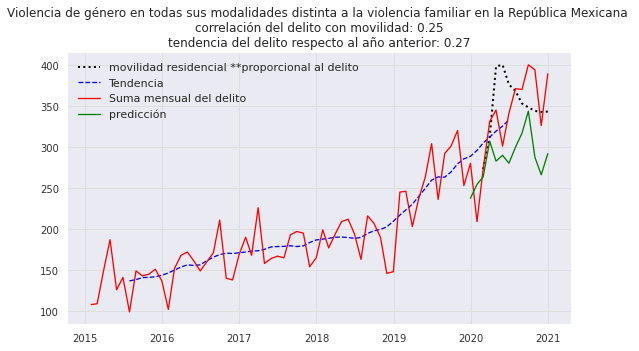

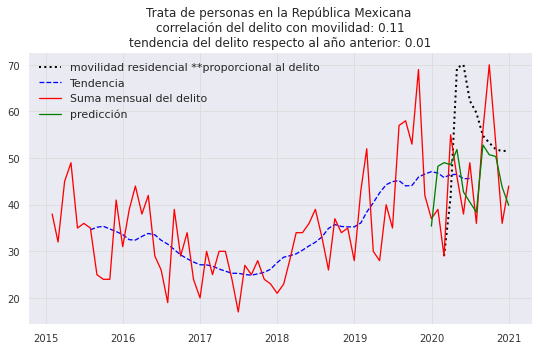

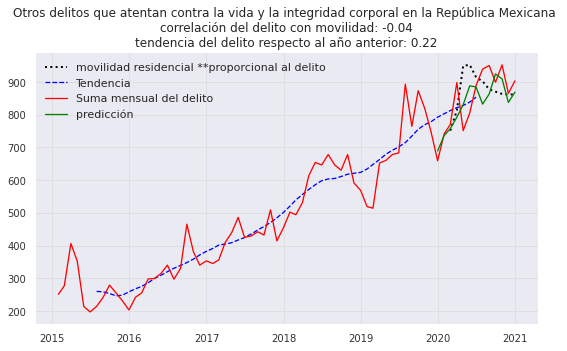

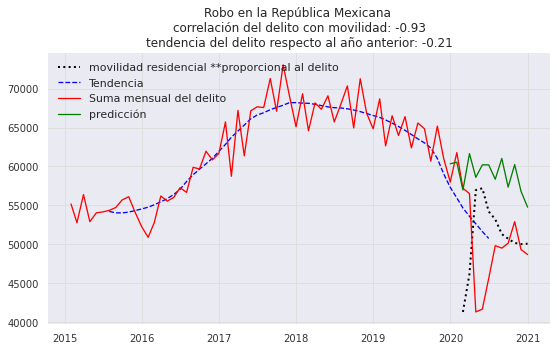

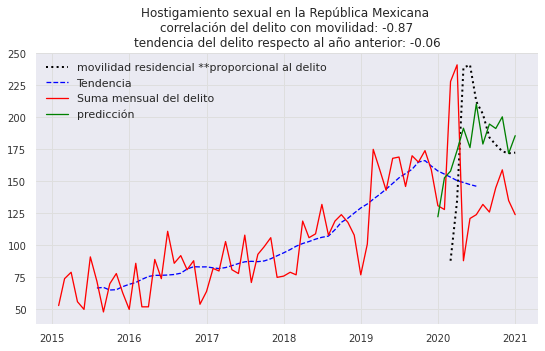

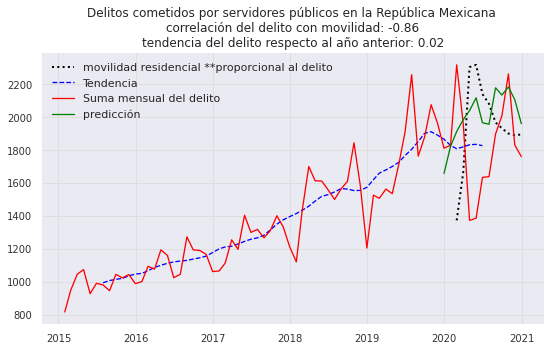

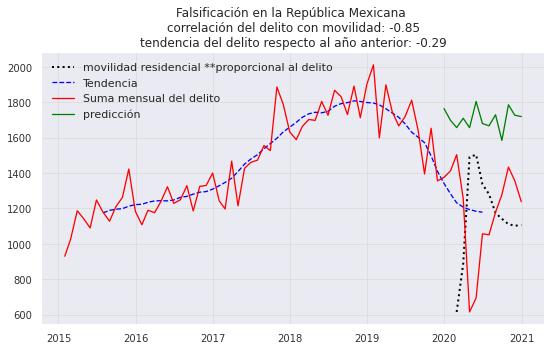

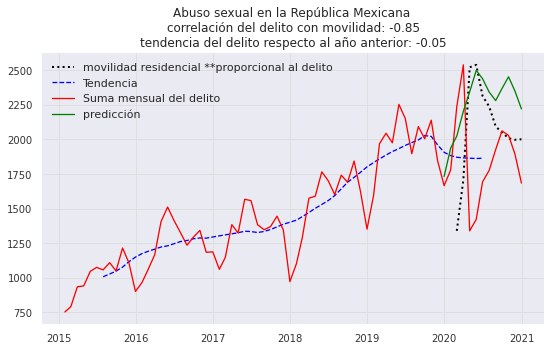

In [14]:
#%%plot df_dsct


for index in [0,1,2,-1,-2,-3,-4,-5]:
    
    index_delito_state = df_dsct.iloc[index,:]
    delito = index_delito_state.loc['delito']
    df_delito = delitos_sum_df[delito]
    
    decom = sm.tsa.seasonal_decompose(df_delito, model = 'additive')
    
    movilidad_spec = df_corr_movilidad.loc[df_corr_movilidad.index < '2021-01-01']
    movilidad_spec.index = pd.to_datetime(movilidad_spec.index)
    movilidad_spec = movilidad_spec['Residences'].resample('M').sum()
    #plot
    fig, ax = plt.subplots() 
    ax.plot(movilidad_spec.index, spec_scaler(series = movilidad_spec, 
                                              minv = df_delito.loc[df_delito.index > '2020-02-15'].resample('M').sum().min(),
                                              maxv = df_delito.loc[df_delito.index > '2020-02-15'].resample('M').sum().max()),
            label = 'movilidad residencial **proporcional al delito',
            linestyle = ':',
            color = 'black',
            linewidth=2)
    ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='blue')
    ax.plot(decom.trend.index, df_delito.resample('M').sum(), label = 'Suma mensual del delito', color='red')
    ax.set_title(delito+' en la República Mexicana '+
                 '\n'+'correlación del delito con movilidad: '+str(round(df_dsct.iloc[index,:]['corr'], 2))+
                 '\n'+'tendencia del delito respecto al año anterior: '+str(round(df_dsct.iloc[index,:]['trend'], 2)))
    df_pred = predict_series(df_delito, delito)
    ax.plot(df_pred.index,
            df_pred.values,
            label = 'predicción',
            color = 'green')
    
    ax.legend(loc='upper left')
    plt.plot()